## 02.Spanish Translation A/B Test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/tylin/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
test_df = pd.read_csv("./data/test_table.csv")
user_df = pd.read_csv("./data/user_table.csv")

In [3]:
test_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
user_df.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
user_df.isna().sum()/user_df.shape[0]

user_id    0.0
sex        0.0
age        0.0
country    0.0
dtype: float64

In [6]:
data_df = test_df.merge(user_df, how="left")

In [7]:
print("no user_id:",data_df.loc[data_df["sex"].isna()].shape[0])

no user_id: 454


In [8]:
data_df.isna().sum()/data_df.shape[0]

user_id             0.000000
date                0.000000
source              0.000000
device              0.000000
browser_language    0.000000
ads_channel         0.598790
browser             0.000000
conversion          0.000000
test                0.000000
sex                 0.001001
age                 0.001001
country             0.001001
dtype: float64

In [9]:
data_df["country"].unique()
# Spanish: Spain, Mexico, Venezuela, Bolivia, Colombia, Uruguay, El Salvador, Nicaragua, Peru
# Costa Rica, Chile, Argentina, Ecuador, Guatemala, Honduras, Paraguay, Panama


array(['Spain', 'Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Costa Rica', 'Chile',
       'Argentina', 'Ecuador', 'Guatemala', 'Honduras', 'Paraguay',
       'Panama', nan], dtype=object)

#### 資料前處理
- 西班牙地區的轉換率特別高，又已經是localization了(test=1)，之後分析會將西班牙地區的資料拿掉避免bias

In [10]:
data_df.groupby("country").mean()["conversion"].sort_values(ascending=False)

country
Spain          0.079719
Costa Rica     0.053494
Nicaragua      0.053399
Colombia       0.051332
El Salvador    0.050765
Mexico         0.050341
Peru           0.050258
Chile          0.049704
Venezuela      0.049666
Guatemala      0.049653
Honduras       0.049253
Ecuador        0.049072
Paraguay       0.048863
Bolivia        0.048634
Panama         0.048089
Argentina      0.013994
Uruguay        0.012821
Name: conversion, dtype: float64

In [11]:
# 移除西班牙地區
ab_df = data_df.loc[data_df["country"]!="Spain"]

## 1. Conﬁrm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
- A/B testing的確有差異，且是non-localization轉換率(48% vs. 43%)比較好

In [12]:
from scipy.stats import chi2_contingency
from itertools import combinations

In [13]:
contingency = pd.crosstab(index=ab_df["test"],columns=ab_df["conversion"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
print("----------------------------------")
print(ab_df.groupby(["test"]).mean()["conversion"])

Omnibus test (p-value): 0.0000
----------------------------------
test
0    0.048330
1    0.043425
Name: conversion, dtype: float64


## 2. Explain why that might be happening. Are the localized translations really worse?

### 2-1 各地區的localization對轉換率
- hypothesis: 各地區翻譯的效果不同，導致不同國家應該有不同轉換率
- non-localization比較好：Argentina, Bolivia, Colombia, Ecuador, El Salvador, Guatemala, Honduras,Venezuela 
- localization後比較好：Chile, Costa Rica, Mexico, Nicaragua, Panama, Paraguay, Peru, Uruguay
- Summary: Localization的效果好不好，要看是哪個國家而定。

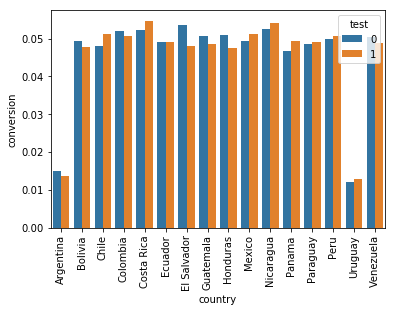

In [14]:
plot_data = ab_df[["test","country","conversion"]].groupby(["country","test"]).mean().reset_index()
plt.xticks(rotation=90)

sns.barplot(data=plot_data, x='country',y='conversion', hue='test')

### 2-2 檢驗兩組的人口組成是否相近
1. source -> 相近
2. device -> 相近
3. browser language -> 相近
4. ads channel -> 相近
5. browser -> 相近
6. sex -> 相近
7. age -> loc年齡更輕
8. country -> loc vs. non-loc. 有差異

Summary: 兩組人口組成有差異，可能導致最終結果的偏差
- non-loc > loc: Ecuador(0.043 vs. 0.036), Mexico(0.345 vs. 0.298) -> 兩者剛好都是轉換率高的國家
- loc > non-loc: Argentina(0.05 vs 0.17) , Uruguay (0.002 vs. 0.017) -> 兩者剛好都是轉換率低的國家

-> 移除掉上面四個國家之後，兩者(loc vs. non-loc)轉換率就沒有顯著性差異了

In [15]:
# 1. source
contingency = pd.crosstab(index=ab_df["source"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")

Omnibus test (p-value): 0.3405


In [16]:
# 2. device
contingency = pd.crosstab(index=ab_df["device"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")

Omnibus test (p-value): 0.2645


In [17]:
# 3. browser language
contingency = pd.crosstab(index=ab_df["browser_language"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")

Omnibus test (p-value): 0.5400


In [18]:
# 4. ads channel 
contingency = pd.crosstab(index=ab_df["ads_channel"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")

Omnibus test (p-value): 0.6690


In [19]:
# 5. browser
contingency = pd.crosstab(index=ab_df["browser"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
contingency/contingency.sum()

Omnibus test (p-value): 0.0206


test,0,1
browser,,
Android_App,0.341255,0.343504
Chrome,0.223302,0.225953
FireFox,0.089741,0.089720
IE,0.136961,0.135400
Iphone_App,0.103112,0.102624
Opera,0.013451,0.013367
Safari,0.092177,0.089433


In [20]:
# 6. sex
contingency = pd.crosstab(index=ab_df["sex"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
contingency/contingency.sum()

Omnibus test (p-value): 0.6816


test,0,1
sex,,
F,0.416036,0.416681
M,0.583964,0.583319


/Users/tylin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tylin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


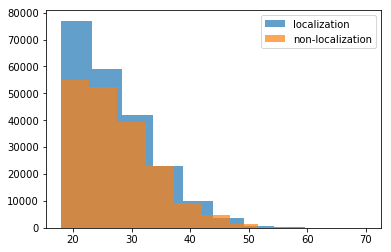

In [21]:
# 7. age
# plotting first histogram
plt.hist(ab_df.loc[ab_df["test"]==1, "age"], label='localization', alpha=.7)
# plotting second histogram
plt.hist(ab_df.loc[ab_df["test"]==0, "age"], label='non-localization', alpha=0.7)
plt.legend()
 
# Showing the plot using plt.show()
plt.show()

In [22]:
# 6. country
contingency = pd.crosstab(index=ab_df["country"],columns=ab_df["test"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
(contingency/contingency.sum())


Omnibus test (p-value): 0.0000


test,0,1
country,,
Argentina,0.050488,0.173223
Bolivia,0.029950,0.025833
Chile,0.053170,0.045807
Colombia,0.146176,0.125001
Costa Rica,0.014354,0.012277
Ecuador,0.043365,0.036422
El Salvador,0.022168,0.018848
Guatemala,0.041131,0.034772
Honduras,0.023533,0.019497


### 不平衡的國家組別

In [23]:
unblance_country =["Argentina","Ecuador","Mexico","Uruguay"]

In [24]:
ab_df.loc[ab_df["country"].isin(unblance_country)].groupby(["country"]).agg("mean")["conversion"]

country
Argentina    0.013994
Ecuador      0.049072
Mexico       0.050341
Uruguay      0.012821
Name: conversion, dtype: float64

In [25]:
clean_df = ab_df.loc[~ab_df["country"].isin(["Argentina","Ecuador","Mexico","Uruguay"])]
contingency = pd.crosstab(index=clean_df["test"],columns=ab_df["conversion"])
chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
print("----------------------------------")
print(clean_df.groupby(["test"]).mean()["conversion"])

Omnibus test (p-value): 0.5106
----------------------------------
test
0    0.050695
1    0.050052
Name: conversion, dtype: float64


## 3. If you identiﬁed what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.
- We should check the distribution of two groups first

In [46]:
def check_dist(df, cat_cols, group):
    problem_col = []
    for cat_col in cat_cols:
        contingency = pd.crosstab(index=df[cat_col],columns=df[group])
        chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
        if p < (0.05/len(cat_cols)):
            problem_col.append(cat_col)
            
    return (True if len(problem_col)==0 else False, problem_col)

In [48]:
# usage
trust, prob_cols = check_dist(ab_df, ["source", "device", "browser_language", "ads_channel", "browser", "sex", "country"], "test")
if not trust:
    for col in prob_cols:
        print(col)

country
